In [1]:
import sys
from pathlib import Path
sys.path = list(set(sys.path + ["../python"]))

In [2]:
import pandas as pd
from gaussian_system import System, time_matrix, log_marginal_entropy_power
path = Path.cwd().parent / "plots"
assert path.exists()
path

PosixPath('/Users/mr/Git/Gillespie/plots')

In [3]:
mc_data = pd.read_json(path / "monte-carlo" / "estimates.json", orient="table")
mc_data["estimate"] = "Monte-Carlo"
replica_data = pd.read_json(path / "replica" / "estimates.json", orient="table")
replica_data["estimate"] = "Replica"

In [4]:
system = System(lamda = 0.005, kappa = 0.25, rho = 0.01, mu = 0.01)

analytical = replica_data.astype(object).apply(lambda s: system.marginal_entropy(time_matrix(s["dim"], s["delta_t"])), axis="columns")
analytical_data = replica_data[["dim", "delta_t"]]
analytical_data["marginal_entropy"] = analytical
analytical_data["estimate"] = "Analytical"

In [5]:
combined_data = pd.concat([analytical_data, mc_data, replica_data])

conditional_entropy = combined_data.astype(object).apply(
    lambda s: system.conditional_entropy(time_matrix(s["dim"], s["delta_t"])),
    axis="columns",
)
combined_data["mutual_information"] = (
    combined_data["marginal_entropy"] - conditional_entropy
)

combined_data

,dim,delta_t,marginal_entropy,estimate,num_responses,num_signals,stderr,intercept,mutual_information
0,100,5.000000,222.213827,Analytical,NaN,NaN,NaN,NaN,1.045673
1,160,3.125000,318.258225,Analytical,NaN,NaN,NaN,NaN,1.054888
2,220,2.272727,402.702430,Analytical,NaN,NaN,NaN,NaN,1.059089
3,280,1.785714,478.823505,Analytical,NaN,NaN,NaN,NaN,1.061493
4,340,1.470588,548.443278,Analytical,NaN,NaN,NaN,NaN,1.063049
5,400,1.250000,612.725782,Analytical,NaN,NaN,NaN,NaN,1.064140
0,100,5.000000,221.998414,Monte-Carlo,1500.0,825000.0,0.178443,NaN,0.830259
1,160,3.125000,318.108383,Monte-Carlo,1500.0,825000.0,0.226275,NaN,0.905047
2,220,2.272727,402.540393,Monte-Carlo,1500.0,825000.0,0.270540,NaN,0.897052
3,280,1.785714,479.136045,Monte-Carlo,1500.0,825000.0,0.306599,NaN,1.374032


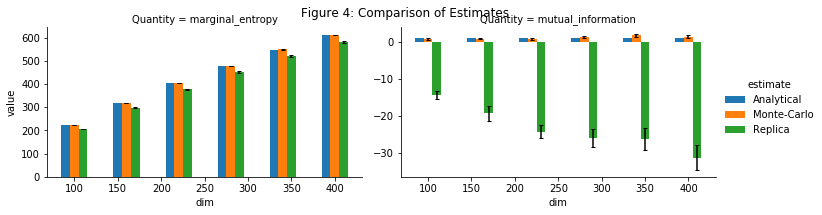

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

grid = sns.FacetGrid(
    col="Quantity",
    hue="estimate",
    sharey=False,
    data=combined_data.melt(
        id_vars=["dim", "delta_t", "estimate", "num_responses", "num_signals", "stderr", "intercept"],
        var_name="Quantity"
    ).fillna(0),
    legend_out=True,
    aspect=1.7
)


def errorbars(x, height, err, estimate, width, **kw_args):
    if estimate.iat[0] == "Analytical":
        x -= width
        kw_args['capsize'] = 0
    if estimate.iat[0] == "Replica":
        x += width
    return plt.bar(x=x, height=height, yerr=err, width=width, **kw_args)


grid = grid.map(errorbars, "dim", "value", "stderr", "estimate", width=10, capsize=2).add_legend()
grid.fig.suptitle('Figure 4: Comparison of Estimates')
grid.savefig(path / "comparison" / "barchart.pdf")